In [289]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [290]:
# Load data from the file
df = pd.read_csv("data/icml_face_data.csv")

In [291]:
# Get know more about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [292]:
df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [293]:
df['emotion'].unique() # probably there will be a need to map numbers to emotions

array([0, 2, 4, 6, 3, 5, 1])

In [294]:
# Create dictionary num -> emotion
# source: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data
numToEmotion = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [295]:
df[' Usage'].unique() # dataset is alredy grouped into train and test subset

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [296]:
type(df[' pixels'].iloc[0])

str

In [297]:
# Standarize column names
df.columns = ['emotion', 'usage', 'pixels']

In [298]:
# Images screening
# Create functinon to show image from pixels
def display_image(row: pd.core.series.Series) -> None:
    pixels = row['pixels']
    emotionNumber = row['emotion']
    
    pixels_array = np.array(pixels.split(" "), 'uint8') / 255
    pixels_reshaped = pixels_array.reshape(48, 48)
    
    plt.imshow(pixels_reshaped, cmap="gray")
    plt.title(numToEmotion[emotionNumber])
    plt.show()

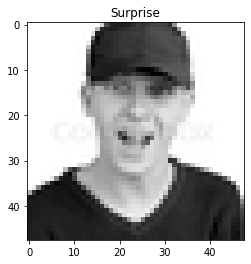

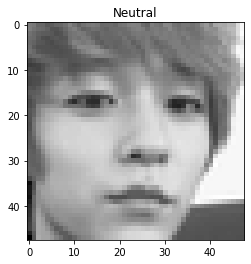

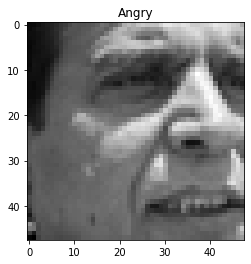

In [299]:
# Display a couple of sample images
display_image(df.iloc[55])
display_image(df.iloc[13])
display_image(df.iloc[23])

In [301]:
# Map pixels as str into numpy array format in the dataset
def map_str_to_array(pixels: str) -> np.array:
    pixels_array = np.array(pixels.split(" "), 'float32') / 255
    pixels_reshaped = np.reshape(pixels_array, (48, 48))
    return pixels_reshaped

df['pixels'] = df['pixels'].map(lambda pixels: map_str_to_array(pixels))

In [302]:
# Split dataset on the base of 'usage' column
df_train = df.loc[df['usage'] == 'Training']
df_val = df.loc[df['usage'] == 'PrivateTest']
df_test = df.loc[df['usage'] == 'PublicTest']

In [319]:
# Prepare data to keras and tensorflow processing
def create_image_and_label_arrays(df: pd.core.frame.DataFrame) -> (np.ndarray, np.ndarray):
    images = df['pixels'].to_numpy()
    images = np.concatenate(images).reshape((images.shape[0],48,48,1))
    labels = df['emotion'].to_numpy()
    return images, labels

images_train, labels_train = create_image_and_label_arrays(df_train)
images_val, labels_val = create_image_and_label_arrays(df_val)
images_test, labels_test = create_image_and_label_arrays(df_test)

In [325]:
# Let's create the model!
# inspiratinon: https://www.tensorflow.org/tutorials/images/classification

emotion_classes = len(df['emotion'].unique())
img_height, img_width = 48, 48

model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 1)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(emotion_classes)
])

In [326]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [327]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 2304)             

In [323]:
class_weight = dict(zip(range(0, 7), (((df[df['usage']=='Training']['emotion'].value_counts()).sort_index())/len(df[df['usage']=='Training']['emotion'])).tolist()))

In [324]:
# Train the model
epochs=10
history = model.fit(
  images_train, labels_train,
  validation_data=(images_val, labels_val),
  class_weight = class_weight,
  epochs=epochs
)

Epoch 1/10
898/898 [==============================] - 26s 28ms/step - loss: 0.2754 - accuracy: 0.2990 - val_loss: 1.5453 - val_accuracy: 0.4146
Epoch 2/10
898/898 [==============================] - 26s 29ms/step - loss: 0.2184 - accuracy: 0.4563 - val_loss: 1.3941 - val_accuracy: 0.4767
Epoch 3/10
898/898 [==============================] - 26s 29ms/step - loss: 0.1951 - accuracy: 0.5171 - val_loss: 1.2759 - val_accuracy: 0.5188
Epoch 4/10
898/898 [==============================] - 25s 27ms/step - loss: 0.1815 - accuracy: 0.5517 - val_loss: 1.2758 - val_accuracy: 0.5210
Epoch 5/10
898/898 [==============================] - 25s 27ms/step - loss: 0.1688 - accuracy: 0.5842 - val_loss: 1.2285 - val_accuracy: 0.5400
Epoch 6/10
898/898 [==============================] - 24s 27ms/step - loss: 0.1563 - accuracy: 0.6135 - val_loss: 1.2461 - val_accuracy: 0.5550
Epoch 7/10
898/898 [==============================] - 24s 27ms/step - loss: 0.1428 - accuracy: 0.6504 - val_loss: 1.2475 - val_accuracy:

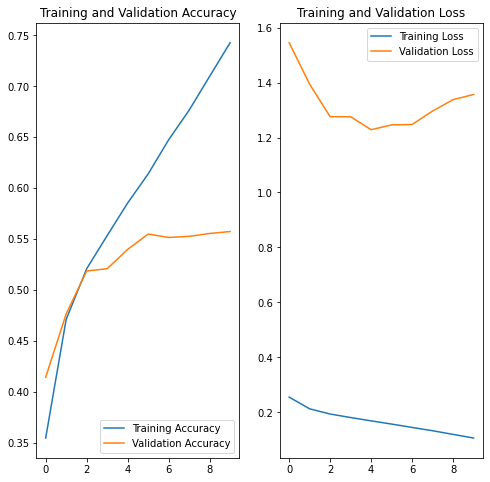

In [328]:
# Visualise trainig results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [329]:
# Todo - analyze unterfitting